In [27]:
# pip install xgboost

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
# Load the datasets
customers_path = 'data_files/brazilian-ecommerce/olist_customers_dataset.csv'
customers = pd.read_csv(customers_path)

orders_path = 'data_files/brazilian-ecommerce/olist_orders_dataset.csv'
orders = pd.read_csv(orders_path)

order_items_path = 'data_files/brazilian-ecommerce/olist_order_items_dataset.csv'
order_items = pd.read_csv(order_items_path)

In [10]:
if not orders.empty:
    # 1. Merge orders and customers
    # This gives us the unique ID for each customer in the orders table
    df = orders.merge(customers, on='customer_id')
    
    # 2. Merge with order_items
    # This gives us the price information for each order
    df = df.merge(order_items, on='order_id')

    print("Data merged. DataFrame shape:", df.shape)
    print(df.head())
else:
    print("Skipping processing as dataset was not loaded.")

Data merged. DataFrame shape: (112650, 18)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1    

In [12]:
if not df.empty:
    # We are interested in customers who actually completed a purchase
    df = df[df['order_status'] == 'delivered'].copy()
    
    # Convert timestamp to datetime object
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    
    # Calculate total price for each item
    df['total_price'] = df['price'] + df['freight_value']
    
    # We only need these columns
    df_clean = df[['customer_unique_id', 'order_purchase_timestamp', 'total_price']]
    
    print("\nCleaned DataFrame:")
    print(df_clean.head())
    print(f"\nData ranges from {df_clean['order_purchase_timestamp'].min()} to {df_clean['order_purchase_timestamp'].max()}")


Cleaned DataFrame:
                 customer_unique_id order_purchase_timestamp  total_price
0  7c396fd4830fd04220f754e42b4e5bff      2017-10-02 10:56:33        38.71
1  af07308b275d755c9edb36a90c618231      2018-07-24 20:41:37       141.46
2  3a653a41f6f9fc3d2a113cf8398680e8      2018-08-08 08:38:49       179.12
3  7c142cf63193a1473d2e66489a9ae977      2017-11-18 19:28:06        72.20
4  72632f0f9dd73dfee390c9b22eb56dd6      2018-02-13 21:18:39        28.62

Data ranges from 2016-09-15 12:16:38 to 2018-08-29 15:00:37


In [14]:
if not df_clean.empty:
    # This is the "present" day. We build features based on what we know up to this day.
    SNAPSHOT_DATE = pd.to_datetime('2018-06-01')
    
    # --- Historical Data (for Features X) ---
    df_historical = df_clean[df_clean['order_purchase_timestamp'] < SNAPSHOT_DATE]
    
    # --- Future Data (for Target y) ---
    df_future = df_clean[df_clean['order_purchase_timestamp'] >= SNAPSHOT_DATE]

    print(f"\nHistorical data points: {len(df_historical)}")
    print(f"Future data points: {len(df_future)}")


Historical data points: 89082
Future data points: 21115


In [16]:
if not df_historical.empty:
    print("\nStarting feature engineering (RFM)...")
    
    # Aggregate data to customer level
    rfm_df = df_historical.groupby('customer_unique_id').agg(
        last_purchase_date=('order_purchase_timestamp', 'max'),
        frequency=('order_purchase_timestamp', 'count'), # Count of items purchased
        monetary=('total_price', 'sum')
    ).reset_index()
    
    # --- Calculate Recency ---
    # Days from SNAPSHOT_DATE to their last purchase
    rfm_df['recency'] = (SNAPSHOT_DATE - rfm_df['last_purchase_date']).dt.days
    
    # Drop the date column, we just need the 'recency' number
    rfm_df = rfm_df.drop('last_purchase_date', axis=1)

    print("RFM features (X) created:")
    print(rfm_df.head())


Starting feature engineering (RFM)...
RFM features (X) created:
                 customer_unique_id  frequency  monetary  recency
0  0000366f3b9a7992bf8c76cfdf3221e2          1    141.90       21
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1     27.19       24
2  0000f46a3911fa3c0805444483337064          1     86.22      447
3  0000f6ccb0745a6a4b88665a16c9f078          1     43.62      231
4  0004aac84e0df4da2b147fca70cf8255          1    196.89      198


In [18]:
if not df_future.empty:
    # Calculate total spend for each customer in the future window
    future_clv_df = df_future.groupby('customer_unique_id').agg(
        future_clv=('total_price', 'sum')
    ).reset_index()

    print("\nFuture CLV (y) created:")
    print(future_clv_df.head())


Future CLV (y) created:
                 customer_unique_id  future_clv
0  000e309254ab1fc5ba99dd469d36bdb4       78.42
1  000ec5bff359e1c0ad76a81a45cb598f       27.75
2  000fbf0473c10fc1ab6f8d2d286ce20c      362.36
3  0015752e079902b12cd00b9b7596276b       74.82
4  00172711b30d52eea8b313a7f2cced02      122.07



Final modeling dataframe:
                 customer_unique_id  frequency  monetary  recency  future_clv
0  0000366f3b9a7992bf8c76cfdf3221e2          1    141.90       21         0.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1     27.19       24         0.0
2  0000f46a3911fa3c0805444483337064          1     86.22      447         0.0
3  0000f6ccb0745a6a4b88665a16c9f078          1     43.62      231         0.0
4  0004aac84e0df4da2b147fca70cf8255          1    196.89      198         0.0

Distribution of Future CLV:
count    75387.000000
mean         0.888465
std         18.109232
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1596.960000
Name: future_clv, dtype: float64


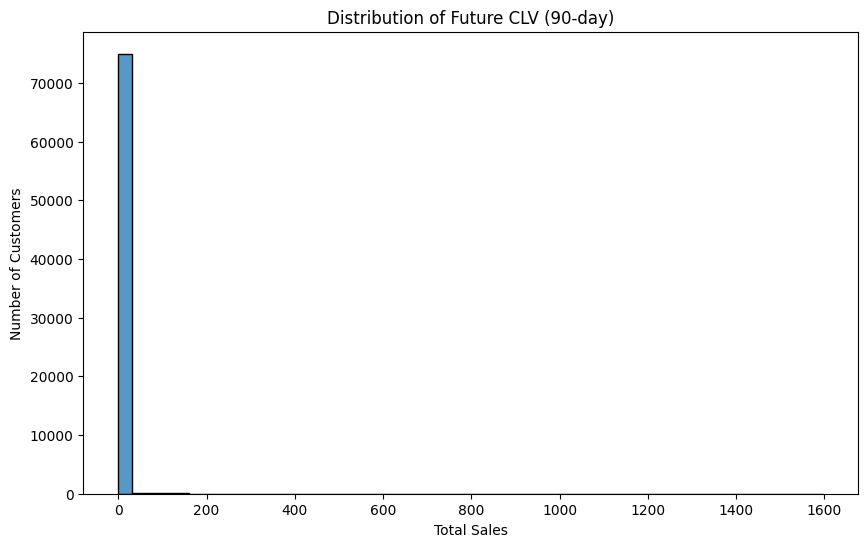

In [21]:
if not rfm_df.empty:
    # Merge features (X) with the target (y)
    final_model_df = rfm_df.merge(future_clv_df, on='customer_unique_id', how='left')
    
    # Customers who didn't buy in the future window will have NaN
    # We must fill this with 0.0
    final_model_df['future_clv'] = final_model_df['future_clv'].fillna(0)
    
    print("\nFinal modeling dataframe:")
    print(final_model_df.head())

    # --- Check distribution of our target variable ---
    print("\nDistribution of Future CLV:")
    print(final_model_df['future_clv'].describe())
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(final_model_df['future_clv'], bins=50, kde=False)
    plt.title('Distribution of Future CLV (90-day)')
    plt.xlabel('Total Sales')
    plt.ylabel('Number of Customers')
    plt.show()

In [23]:
if not final_model_df.empty:
    # 1. Define X and y
    X = final_model_df[['recency', 'frequency', 'monetary']]
    y = final_model_df['future_clv']
    
    # 2. Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 3. Scale Features
    # Scaling is not strictly required for XGBoost, but it's good practice
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Train XGBoost Regressor
    print("\n--- Training XGBoost Model ---")
    xgb = XGBRegressor(objective='reg:squarederror', 
                         n_estimators=100, 
                         learning_rate=0.1,
                         random_state=42)
    
    xgb.fit(X_train_scaled, y_train)
    print("Model training complete.")


--- Training XGBoost Model ---
Model training complete.



--- Model Evaluation ---
Root Mean Squared Error (RMSE): 19.27
R-squared (R2): -0.330

--- Feature Importance ---
     feature  importance
2   monetary    0.442815
0    recency    0.366186
1  frequency    0.190999


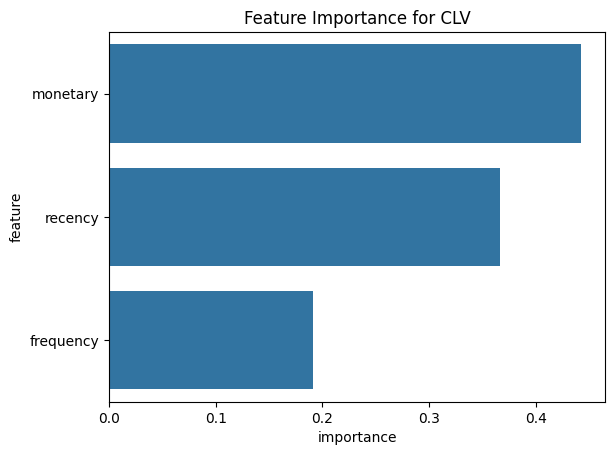

In [25]:
if 'xgb' in locals():
    # 5. Make Predictions
    y_pred = xgb.predict(X_test_scaled)
    
    # 6. Evaluate Model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("\n--- Model Evaluation ---")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.3f}")

    # 7. Check Feature Importance
    print("\n--- Feature Importance ---")
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(importance_df)
    
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Feature Importance for CLV')
    plt.show()